In [1]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 374 (delta 146), reused 121 (delta 86), pack-reused 175 (from 1)
Receiving objects: 100% (374/374), 1.41 MiB | 15.23 MiB/s, done.
Resolving deltas: 100% (245/245), done.
/content/InkubaLM-Challenge


In [2]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge
Already up to date.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install -U trl bitsandbytes

In [5]:
!pip install datasets

In [6]:
import sys
from pathlib import Path


import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datasets import (
    load_dataset,
    concatenate_datasets,
    Dataset,
    Value
)
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    PeftModel
)
from trl import (
    SFTConfig,
    SFTTrainer,
    DataCollatorForCompletionOnlyLM
)

from utils import (
    eval,
    model_function,
    supplement,
    multitask,
    ab_testing
)


In [7]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is enabled:", torch.cuda.get_device_name(0))
else:
    print('not using GPU')


✅ GPU is enabled: Tesla T4


In [8]:
!nvidia-smi


Fri Apr 11 13:36:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [11]:
from huggingface_hub import login

try:
    from google.colab import userdata
    os.environ["hf_token_2"] = userdata.get("hf_token_2")
except:
    os.environ["hf_token_2"] = "----"

login(token=os.environ["hf_token_2"])

token = os.environ["hf_token_2"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)

In [12]:
hf_token_2 = '...'
os.environ["HF_TOKEN"] = hf_token_2

## **Load and Explore Datasets**

In [13]:
print("# Loading datasets")
se_dataset, mt_dataset,xn_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")


# Loading datasets


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

All Columns: ['instruction', 'task', 'data_source', 'targets', 'inputs', 'premise', 'ID', 'langs']


Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/486 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/484 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

All Columns: ['instruction', 'task', 'data_source', 'targets', 'inputs', 'premise', 'ID', 'langs']


Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

In [15]:
combined_dataset = concatenate_datasets([se_dataset, mt_dataset, xn_dataset])
train_df = combined_dataset.to_pandas()

# **Data Augmentation**

###**Problem:** sentiment analysis classes are heavily skewed towards neutral class for Swahili.

### **Solution**: supplement dataset with various augmentation techniques:
- **synonym replacement**
- **random swap**
- **random deletion** (produces data that is more similar to social media posts)

In [16]:
import re

def extract_task_from_id(id_str):
    match = re.search(r'afrixnli|mt|sentiment', id_str)
    return match.group(0) if match else None

train_df['task'] = train_df['ID'].apply(extract_task_from_id)



In [17]:
def repeat_target_tokens_to_length(df, tokenizer, target_length=11, task_column='task', target_column='targets',
                                   reference_task='mt', verbose=True, n_debug=3):
    """
    Repeat the target string until its tokenized length >= target_length.
    Only applies to tasks other than the reference task (e.g. sentiment, afrixnli).
    No filler tokens are used.
    """
    df = df.copy()

    # Map AfriXNLI numeric labels to text
    xnli_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
    if 'afrixnli' in df[task_column].unique():
        if df[df[task_column] == 'afrixnli'][target_column].dtype != object:
            df.loc[df[task_column] == 'afrixnli', target_column] = df.loc[df[task_column] == 'afrixnli', target_column].map(xnli_map)

    def repeat_until_token_length(text):
        text = str(text).strip()
        if not text:
            return text
        repeated = text
        while len(tokenizer(repeated).input_ids) < target_length:
            repeated += ' ' + text
        return repeated.strip()

    for task in df[task_column].unique():
        if task != reference_task:
            mask = df[task_column] == task
            if verbose:
                print(f"\n--- Padding task: {task} ---")
            examples = df.loc[mask, target_column].tolist()

            new_targets = []
            for i, text in enumerate(examples):
                padded = repeat_until_token_length(text)
                new_targets.append(padded)

                if verbose and i < n_debug:
                    orig_len = len(tokenizer(text).input_ids)
                    pad_len = len(tokenizer(padded).input_ids)
                    print(f"Original: '{text}'")
                    print(f"Padded:   '{padded}'")
                    print(f"Token lengths: original={orig_len}, padded={pad_len}")
                    print("-" * 30)

            df.loc[mask, target_column] = new_targets

    return df

In [21]:
df_padded = repeat_target_tokens_to_length(train_df, tokenizer, target_length=19)
df_padded['target_len'] = df_padded['targets'].apply(lambda x: len(tokenizer(x).input_ids))
print(df_padded.groupby('task')['target_len'].describe())



--- Padding task: sentiment ---
Original: 'Kyakkyawa'
Padded:   'Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa'
Token lengths: original=5, padded=21
------------------------------
Original: 'Tsaka-tsaki'
Padded:   'Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki'
Token lengths: original=6, padded=21
------------------------------
Original: 'Wastani'
Padded:   'Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani'
Token lengths: original=3, padded=19
------------------------------

--- Padding task: afrixnli ---
Original: '0'
Padded:   '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'
Token lengths: original=2, padded=19
------------------------------
Original: '0'
Padded:   '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'
Token lengths: original=2, padded=19
------------------------------
Original: '1'
Padded:   '1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1'
Token lengths: original=2, padded=19
------------------------------
           count       mean        std   min   25%   50%   75%    max

In [23]:
df_padded['target_len'] = df_padded['targets'].apply(lambda x: len(tokenizer(x).input_ids))
df_padded.groupby('task')['target_len'].describe()


,count,mean,std,min,25%,50%,75%,max
task,,,,,,,,
afrixnli,400.0,19.000000,0.000000,19.0,19.0,19.0,19.0,19.0
mt,600.0,19.351667,13.182981,4.0,10.0,16.0,24.0,105.0
sentiment,400.0,19.640000,0.934121,19.0,19.0,19.0,21.0,21.0


# **Balance Target Token Lengths**

The Lelapa AI Buzuzu-Mavi Challenge is a multitask learning problem because the model needs to be able to do sentiment analysis, natural language inference (XNLI) and machine translation.


If the target token lengths are not balanced, this will cause the model to **over-prioritise** longer tasks.


### **How can you fix this?**
- **Repeating short targets**: (e.g., "positive" → "positive positive positive...") to match the average target lenght of the reference task (in this case it is translation)
- This ensures that **all tasks contribute more equally** to the total training loss and the **model doesn't ignore short-output tasks** like classification.


In [24]:
balanced_dataset = Dataset.from_pandas(df_padded.reset_index(drop=True))

In [25]:
model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = multitask.setup_model_and_tokenizer(model_name, token=token,use_4bit=False)

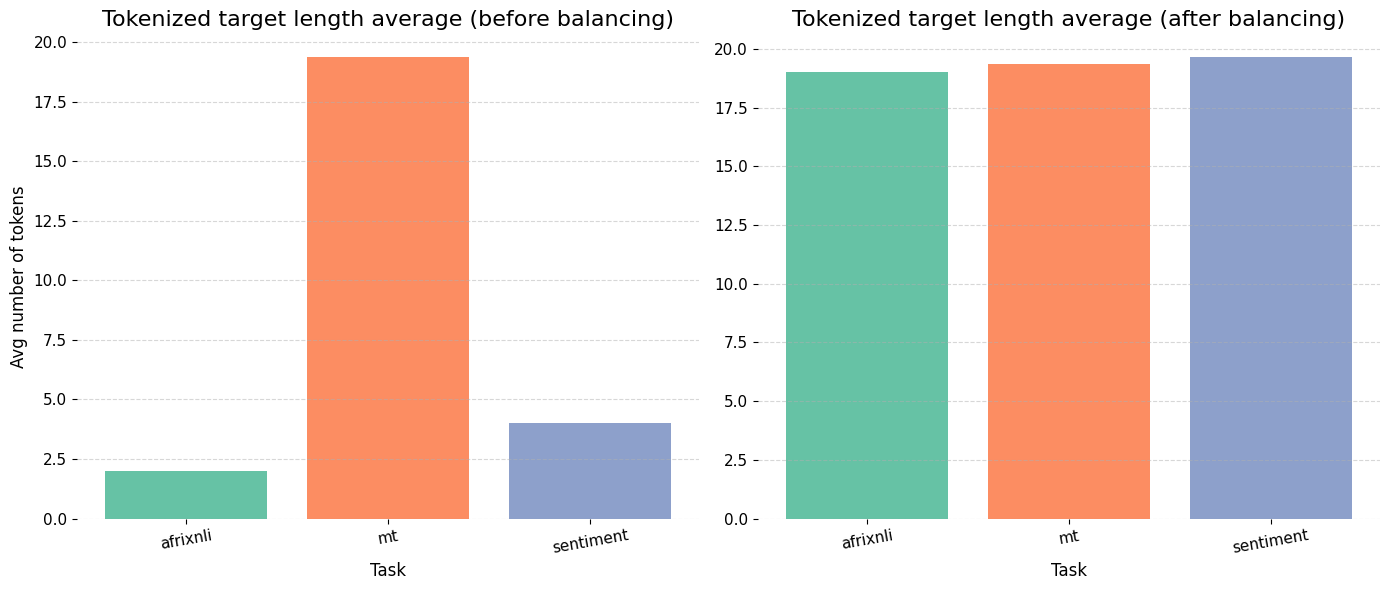

In [26]:
def plot_target_lengths(df_before, df_after, tokenizer, task_column='task'):
    """
    Plot average tokenized target lengths before and after balancing.
    """
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    tasks = sorted(df_before[task_column].unique())
    colors = plt.cm.Set2.colors[:len(tasks)]
    color_map = {task: colors[i] for i, task in enumerate(tasks)}

    # Compute actual tokenized lengths
    lengths_before = {
        task: df_before[df_before[task_column] == task]['targets']
        .apply(lambda x: len(tokenizer(str(x)).input_ids))
        .mean()
        for task in tasks
    }

    lengths_after = {
        task: df_after[df_after[task_column] == task]['targets']
        .apply(lambda x: len(tokenizer(str(x)).input_ids))
        .mean()
        for task in tasks
    }

    # Plot BEFORE
    ax1.bar(lengths_before.keys(), lengths_before.values(),
            color=[color_map[task] for task in tasks])
    ax1.set_title("Tokenized target length average (before balancing)", fontsize=16)
    ax1.set_ylabel("Avg number of tokens", fontsize=12)
    ax1.set_xlabel("Task", fontsize=12)

    # Plot AFTER
    ax2.bar(lengths_after.keys(), lengths_after.values(),
            color=[color_map[task] for task in tasks])
    ax2.set_title("Tokenized target length average (after balancing)", fontsize=16)
    ax2.set_xlabel("Task", fontsize=12)

    for ax in (ax1, ax2):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='x', labelrotation=10, labelsize=11)
        ax.tick_params(axis='y', labelsize=11)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_target_lengths(train_df, df_padded, tokenizer)


In [27]:
mt_lengths = train_df[train_df['task'] == 'mt']['targets'].apply(lambda x: len(tokenizer(str(x)).input_ids))
print(mt_lengths.describe())


count    600.000000
mean      19.351667
std       13.182981
min        4.000000
25%       10.000000
50%       16.000000
75%       24.000000
max      105.000000
Name: targets, dtype: float64


In [38]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM

# Step 2: Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # depends on model arch
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

qlora_model = get_peft_model(model, lora_config)

# Step 3: Setup trainer
trainer = multitask.setup_trainer(
    model=qlora_model,
    dataset=balanced_dataset,  # your already-prepared dataset
    tokenizer=tokenizer,
    output_dir="./sft_model/balanced_lora_fix"
)

# Step 4: Train
trainer.train()


Applying formatting function to train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1400 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.538500
20,0.491200
30,0.591400
40,0.510400
50,0.404900
60,0.374500
70,0.506100
80,0.486000
90,0.565200
100,0.470500


TrainOutput(global_step=261, training_loss=0.49196301771763185, metrics={'train_runtime': 394.855, 'train_samples_per_second': 10.637, 'train_steps_per_second': 0.661, 'total_flos': 1578019576135680.0, 'train_loss': 0.49196301771763185})

In [39]:
merged_model = qlora_model.merge_and_unload()

In [40]:
# Step 6: Push to Hugging Face
from huggingface_hub import login
login()  # paste your HF token

merged_model.push_to_hub("melissafasol/Inkuba_QLoRA")
tokenizer.push_to_hub("melissafasol/Inkuba_QLoRA")

model.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/991k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/melissafasol/Inkuba_QLoRA/commit/5905c924fc083387b4cd05cb75adb6d625351794', commit_message='Upload tokenizer', commit_description='', oid='5905c924fc083387b4cd05cb75adb6d625351794', pr_url=None, repo_url=RepoUrl('https://huggingface.co/melissafasol/Inkuba_QLoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='melissafasol/Inkuba_QLoRA'), pr_revision=None, pr_num=None)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [41]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("melissafasol/Inkuba_QLoRA", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("melissafasol/Inkuba_QLoRA")


config.json:   0%|          | 0.00/784 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/991k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

In [ ]:
from datasets import concatenate_datasets

# Combine the tuple into a list
test_dataset_list = list(test_dataset)

# Concatenate all the datasets into one
combined_test_dataset = concatenate_datasets(test_dataset_list)

In [ ]:
combined_test_dataset

Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', 'premise'],
    num_rows: 900
})

In [ ]:
v2_path = os.path.join(output_dir, "sft_model/balanced_supp/checkpoint-351-v4")
os.makedirs(v2_path, exist_ok=True)
inference_model = model.eval()
results_df = multitask.apply_inference_to_test_data_xnli_change(inference_model, tokenizer, combined_test_dataset)


Generating responses:   0%|          | 0/900 [00:00<?, ?it/s]

In [ ]:
results_df[['ID', 'Response']].to_csv(os.path.join(output_dir,'submission_full_finetune_v4.csv'), index=False)
results = results_df[['ID', 'generated','Response']]

In [ ]:

from google.colab import files

# Save your CSV
output_path = os.path.join(output_dir, 'submission_full_finetune_v4.csv')
results_df[['ID', 'Response']].to_csv(output_path, index=False)

# Download the file
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission_csv = results_df[['ID','Response']]